<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Topic-Modeling" data-toc-modified-id="Topic-Modeling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Topic Modeling</a></span><ul class="toc-item"><li><span><a href="#Dimension-reduction-with-NMF-algorithm" data-toc-modified-id="Dimension-reduction-with-NMF-algorithm-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Dimension reduction with NMF algorithm</a></span></li><li><span><a href="#Graph-of-Words-(GoW)" data-toc-modified-id="Graph-of-Words-(GoW)-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Graph of Words (GoW)</a></span></li><li><span><a href="#Latent-Dirichlet-Allocation-(LDA)" data-toc-modified-id="Latent-Dirichlet-Allocation-(LDA)-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Latent Dirichlet Allocation (LDA)</a></span></li></ul></li><li><span><a href="#Assigning-topics-to-each-sentence-with-LDA" data-toc-modified-id="Assigning-topics-to-each-sentence-with-LDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Assigning topics to each sentence with LDA</a></span></li><li><span><a href="#Labeling" data-toc-modified-id="Labeling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Labeling</a></span></li></ul></div>

# CC Week - SESSION 3 => Topic Extraction and Labeling

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
import seaborn as sns
from sklearn import preprocessing
import string
import gensim
from gensim import corpora
from gensim.models import phrases, Phrases, coherencemodel
from nltk import word_tokenize
from tqdm import tqdm # for progress bar
from tqdm import tqdm_notebook
tqdm.pandas(desc='progress-bar')
tqdm_notebook().pandas()
import langdetect # to detect language
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Topic Modeling

In [2]:
with open('reviews_preprocessed.pickle', 'rb') as input:
    df = pickle.load(input)
with open('allTokens.pickle', 'rb') as input:
    allTokens = pickle.load(input)

### Dimension reduction with NMF algorithm

Less powerful than LDA, NMF gives us a quick way to visualize topics

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [4]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=3, stop_words='english') # set the parameters for automatic selection of words

In [5]:
TermDocument = tfidf_vectorizer.fit_transform(df.review) # feed with your articles

In [6]:
n_dimensions = 6 # This can also be interpreted as topics in this case. This is the "beauty" of NMF. 6 is arbitrary
nmf = NMF(n_components=n_dimensions, random_state=42, alpha=.1, l1_ratio=.5).fit(TermDocument) 

In [7]:
W = nmf.fit_transform(TermDocument)
H = nmf.components_

In [8]:
words = tfidf_vectorizer.get_feature_names()
n_top_words = 10 # print 10 words by dimension. You can change this number

# Loop for each dimension: what words are the most dominant in each dimension
for i_dimension, dimension in enumerate(nmf.components_):
    print("Topic #%d:" % i_dimension)
    print(" ".join([words[i] for i in dimension.argsort()[:-n_top_words - 1:-1]]))
print()

Topic #0:
good food place really just time like table bar came
Topic #1:
great food service place amazing atmosphere staff friendly recommend good
Topic #2:
chicken pork ramen soup fried noodles rice spicy dumplings good
Topic #3:
delicious restaurant pasta dish salad ordered sauce cheese steak bread
Topic #4:
brunch eggs toast french breakfast pancakes benedict coffee egg sunday
Topic #5:
pizza crust pizzas best slice pepperoni cheese pie margherita italian



### Graph of Words (GoW)

In [106]:
import networkx as nx
text = select_corpus()

In [107]:
def word_neighbors(dist):
    return pd.concat([pd.DataFrame([sentence[:-dist], sentence[dist:]]).T for sentence in text]).rename(columns={0:'w0', 1:'w1'}).reset_index(drop=True)

In [108]:
# This creates a huge table of all the words that are neighbors and 2nd-order neighbors
# For neighbors we use weight = 2, for 2nd-order neighbors we use weight = 1
data_graph_of_words = word_neighbors(1).assign(weight=2).append(word_neighbors(2).assign(weight=1))
data_graph_of_words.head()

,w0,w1,weight
0,junior,since,2
1,since,small,2
2,small,child,2
3,child,mom,2
4,mom,always,2


(0, 30)

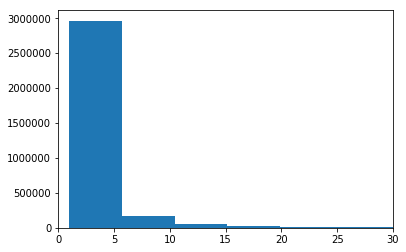

In [109]:
data_graph_of_words = data_graph_of_words.groupby(['w0', 'w1']).weight.sum().reset_index()
plt.hist(data_graph_of_words.weight,bins=500)
plt.xlim(0,30)

In [110]:
data_graph_of_words = data_graph_of_words[data_graph_of_words['weight']>5]

In [111]:
graph_of_words = nx.from_pandas_edgelist(data_graph_of_words, source='w0', target='w1', edge_attr='weight', create_using=nx.Graph())

In [ ]:
graph_of_words_center = nx.ego_graph(graph_of_words, n='restaurant', radius=1)

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\layout.py:499: RuntimeWarning: invalid value encountered in sqrt
  distance = np.sqrt((delta**2).sum(axis=0))


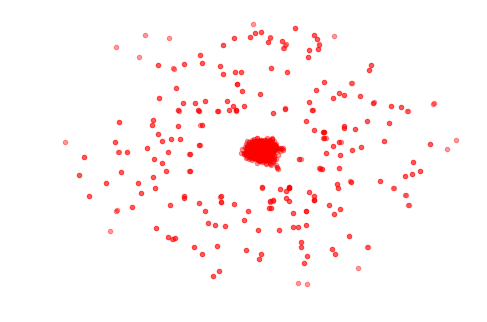

In [95]:
nx.draw(graph_of_words,node_size = 20,alpha=0.4)

### Latent Dirichlet Allocation (LDA)

select_corpus() is a function to return all words in a single List, that we will use for LDA

In [14]:
def select_corpus():
    allWords=[]
    for sent in allTokens:
        for word in sent:
            allWords.append(word)
    return allWords

In [15]:
tokens_for_lda = select_corpus()
dictionary = corpora.Dictionary(tokens_for_lda)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in tokens_for_lda]

In [16]:
number_of_topics = 5
#Lda = gensim.models.ldamodel.LdaModel
#ldamodel = Lda(doc_term_matrix,num_topics = number_of_topics, id2word = dictionary,passes=4,random_state=42,alpha=[0.1]*number_of_topics,eta=[0.01]*len(dictionary))

#ldamodel.save('lda5.model')
ldamodel = gensim.models.ldamodel.LdaModel.load('lda5.model')

In [12]:
# Compute Coherence Score
coherence_model_lda = coherencemodel.CoherenceModel(model=ldamodel, texts=tokens_for_lda, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4261802775865922


Visualization with pyLDAvis library (<b>conda install -c memex pyldavis</b>)

In [13]:
### set lambda to 0.6
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
reviews_vis = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)
pyLDAvis.display(reviews_vis)

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))



Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [23/Jul/2018 09:43:19] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [23/Jul/2018 09:43:19] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [23/Jul/2018 09:43:19] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [23/Jul/2018 09:43:19] "GET /LDAvis.js HTTP/1.1" 200 -
127.0.0.1 - - [23/Jul/2018 09:43:19] code 404, message Not Found
127.0.0.1 - - [23/Jul/2018 09:43:19] "GET /favicon.ico HTTP/1.1" 404 -



stopping Server...


In [15]:
#Careful, number assigned to a topic is different from real ldamodel to pyLDAvis 
topics = ldamodel.show_topics()
for i, el in topics:
    print('{} : \n{}\n'.format(i,el))

0 : 
0.010*"fry" + 0.010*"pizza" + 0.009*"cheese" + 0.008*"taste" + 0.008*"burger" + 0.008*"sandwich" + 0.008*"bite" + 0.008*"side" + 0.007*"sauce" + 0.007*"flavor"

1 : 
0.013*"table" + 0.012*"time" + 0.011*"take" + 0.011*"say" + 0.010*"wait" + 0.009*"ask" + 0.008*"go" + 0.008*"service" + 0.008*"even" + 0.008*"want"

2 : 
0.019*"dish" + 0.013*"delicious" + 0.013*"service" + 0.011*"dessert" + 0.011*"pasta" + 0.010*"dinner" + 0.009*"amaze" + 0.009*"menu" + 0.008*"meal" + 0.008*"appetizer"

3 : 
0.013*"chicken" + 0.012*"dish" + 0.009*"taste" + 0.009*"spicy" + 0.008*"rice" + 0.008*"noodle" + 0.008*"ramen" + 0.008*"eat" + 0.007*"taco" + 0.007*"pretty"

4 : 
0.016*"drink" + 0.016*"service" + 0.013*"nice" + 0.012*"bar" + 0.011*"spot" + 0.010*"brunch" + 0.010*"delicious" + 0.010*"amaze" + 0.008*"menu" + 0.008*"time"



Creating a dictionary to map categories to LDA topics. If we want to skip a category in LDA which is not relevant, just don't put it in the dictionnary (Ambience, Food and Service)

In [23]:
dict_topic = {0:'F',1:'S',2:'F',3:'F',4:'A'}

## Assigning topics to each sentence with LDA

Let's use a sentence tokenizer and build a new dataframe assigning each sentence to its original review

In [17]:
df2 = pd.DataFrame({'review':df.review,'rating':df.stars})
df2['review'] = df2['review'].progress_apply(lambda x: nltk.sent_tokenize(x))
df2['number'] = range(len(df2))
df2.reset_index(drop=True,inplace=True)

Here is the preprocessing function that we used last session. We will need it later on

In [18]:
more_stopwords=['food','place','good','like','get','order','one','back','try','really','would','restaurant','come','also','make','love','great','n\'t','...','\'ve','\'re']
exclude = set(string.punctuation)
stopW = stopwords.words('english')
lemma = WordNetLemmatizer()

def preprocessing(sent):
    tokens = word_tokenize(sent)
    tokens = [w.lower() for w in tokens if w.lower() not in stopW]   
    tokens = [w for w in tokens if len(w)>2]
    tokens = [lemma.lemmatize(lemma.lemmatize(lemma.lemmatize(w,pos='a'),pos='v'),pos='n') for w in tokens]
    tokens = [w for w in tokens if w not in exclude]
    tokens = [w for w in tokens if w not in more_stopwords]    
    return tokens

In [19]:
df_sentences = pd.DataFrame()
numbers = []
sentences = []
stars = []
for i in tqdm(range(df2.shape[0])):
    for sent in df2.at[i,'review']:
        numbers.append(df2.loc[i,'number'])
        sent = sent.replace('.','').replace(',','').replace(':','').replace('!','').replace('?','')
        sentences.append(sent)
        stars.append(df2.rating[i])
df_sentences['numbers']=numbers
df_sentences['sentence']=[lemma.lemmatize(lemma.lemmatize(lemma.lemmatize(sentence.lower(),pos='a'),pos='v'),pos='n').split() for sentence in sentences]
df_sentences['stars']=stars

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83783/83783 [00:21<00:00, 3893.11it/s]


Convert each sentence into gensim bag of words model

In [20]:
df_sentences['corpus'] = df_sentences['sentence'].progress_apply(lambda x: dictionary.doc2bow(x))

Getting topics probability for each sentence

In [21]:
df_sentences['topic'] = df_sentences['corpus'].progress_apply(lambda x: ldamodel.get_document_topics(x))

Getting first top probability

In [24]:
def check_topic(nb_topic):
    if nb_topic[0][0] in dict_topic.keys():
        return dict_topic[nb_topic[0][0]]
    else:
        return dict_topic[nb_topic[1][0]]

df_sentences['sorted_topic'] = df_sentences['topic'].progress_apply(lambda x: sorted(x, key=lambda k:k[1],reverse=True))
df_sentences['best_topic'] = df_sentences['sorted_topic'].progress_apply(lambda x: check_topic(x))   

In [25]:
df_sentences.head()

,numbers,sentence,stars,corpus,topic,sorted_topic,best_topic
0,0,"[i've, been, coming, to, juniors, since, i, wa...",5,"[(4, 1), (20, 1), (22, 1)]","[(0, 0.028578734), (1, 0.8856686), (2, 0.02857...","[(1, 0.8856686), (3, 0.028590193), (4, 0.02858...",S
1,0,"[my, mom, loves, the, food, here, so, always, ...",5,"[(0, 1), (2, 1), (5, 1), (16, 1), (28, 1), (94...","[(0, 0.015386203), (1, 0.37376368), (2, 0.0153...","[(4, 0.58007693), (1, 0.37376368), (3, 0.01538...",A
2,0,"[i, like, all, the, food, though]",5,"[(27, 1)]","[(0, 0.06669899), (1, 0.066679195), (2, 0.0666...","[(3, 0.73326457), (0, 0.06669899), (4, 0.06668...",F
3,0,"[we, came, here, the, other, night, specifical...",5,"[(3, 1), (6, 1), (17, 1), (23, 1), (13522, 1)]","[(0, 0.022225976), (1, 0.022235218), (2, 0.911...","[(2, 0.91108406), (1, 0.022235218), (4, 0.0222...",F
4,0,"[anytime, i'm, downtown, bk, i, try, and, stop...",5,"[(1, 1), (8, 1), (9, 1), (12, 1), (21, 1), (24...","[(0, 0.42555308), (1, 0.013337116), (2, 0.0133...","[(4, 0.5344384), (0, 0.42555308), (1, 0.013337...",A


In [26]:
df_sentences['best_topic'].value_counts()

F    371211
S    204278
A    151682
Name: best_topic, dtype: int64

In [27]:
df_sentences = df_sentences.loc[:,['numbers','stars','sentence','best_topic']]
df_sentences.head()

,numbers,stars,sentence,best_topic
0,0,5,"[i've, been, coming, to, juniors, since, i, wa...",S
1,0,5,"[my, mom, loves, the, food, here, so, always, ...",A
2,0,5,"[i, like, all, the, food, though]",F
3,0,5,"[we, came, here, the, other, night, specifical...",F
4,0,5,"[anytime, i'm, downtown, bk, i, try, and, stop...",A


## Labeling

We will select a random sample of 2000 reviews to label by hand. This will help us to build a classifier more precise than LDA only 

In [3]:
allSent=[]
for r in tqdm(df.review):
    for sent in nltk.sent_tokenize(r):
        allSent.append(sent)

df_sentences['sentence']=allSent
df_sentences = df_sentences[['numbers','stars','sentence','best_topic']]
df_sentences.head()

 71%|████████████████████████████████████████████████████▎                     | 59247/83783 [00:18<00:07, 3177.26it/s]

KeyboardInterrupt: 

In [30]:
import random
idx = random.sample(range(0, df_sentences.numbers.nunique()), 2000)
df_tolabel = df_sentences[df_sentences['numbers'].isin(idx)]
df_tolabel.to_excel('df_sentences_tolabel.xlsx',index=False)

In [17]:
df_labeled = pd.read_excel('df_sentences_labeled.xlsx')

In [18]:
df_labeled.dropna(subset=['label'],inplace=True)
df_labeled.drop(['best_topic'], axis=1, inplace=True)
df_labeled.reset_index(drop=True,inplace=True)

In [19]:
df_labeled.head()

,index,numbers,stars,sentence,label,star_label
0,182,14,5,It used to be a smaller place but now it's pre...,A,4.0
1,183,14,5,The decor is simple and effective.,A,4.0
2,184,14,5,Service is good.,S,4.0
3,185,14,5,"Open kitchen, just the way I like it.",A,4.0
4,186,14,5,I liked how our server suggested what kind of ...,S,4.0


Let's save df_labeled

In [20]:
with open('df_labeled.pickle', 'wb') as output:
    pickle.dump(df_labeled, output)